
# Optimization For Data Science project

## Random point generation

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import heapq
from scipy.linalg import eigh
from sklearn.metrics import accuracy_score
import time
from ucimlrepo import fetch_ucirepo
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter
from sklearn.decomposition import PCA

In [3]:
np.random.seed(0)

Function for points generation

In [4]:
def generate_points(n=1000, n_features=2, centers=2, plot=False, pairplot=False):
    X, y = make_blobs(n_samples=n, n_features=n_features, random_state=0, centers=centers)
    y = 2 * y - 1  # transform labels to -1/+1

    if plot:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            X[:, 0], X[:, 1],
            c=y, cmap='bwr', edgecolor='k', s=60, alpha=0.8
        )
        plt.title("Generated Points", fontsize=16, pad=15)
        plt.xlabel("Feature 1", fontsize=14)
        plt.ylabel("Feature 2", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

    if pairplot:
        # Create DataFrame for seaborn
        df = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(n_features)])
        df['Label'] = y

        sns.pairplot(
            df,
            vars=df.columns[:-1],
            hue='Label',
            palette='bwr',
            plot_kws={'s': 30, 'edgecolor': 'k', 'alpha': 0.7}
        )
        plt.suptitle("Pairplot of Generated Features", fontsize=16, y=1.02)
        plt.show()

    return X, y

Function to download the real dataset

In [5]:
def download_bank(plot=False, pairplot=False, pca_analysis=True):
    # Fetch dataset
    bank = fetch_ucirepo(id=267)

    # Data (as pandas DataFrames)
    X = bank.data.features.copy()
    y = bank.data.targets.copy()

    y.columns = ['target']
    y['target'] = 2 * y['target'] - 1  # Transform to -1 / 1

    # Join X and y for plotting convenience
    df = pd.concat([X, y], axis=1)

    if pca_analysis:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        print("\n=== PCA Analysis ===")
        for i, var in enumerate(pca.explained_variance_ratio_):
            print(f"Component {i+1}: {var*100:.2f}% variance explained")

        features = X.columns
        for i, component in enumerate(pca.components_):
            print(f"\nTop features per PC{i+1}:")
            sorted_features = sorted(zip(features, component),
                                   key=lambda x: abs(x[1]),
                                   reverse=True)
            for feat, weight in sorted_features[:3]:
                print(f"- {feat}: {weight:.3f}")

    if plot:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            X.iloc[:, 0], X.iloc[:, 1],
            c=y['target'], cmap='bwr', edgecolor='k', s=60, alpha=0.8
        )
        plt.title("First Two Features Colored by Target", fontsize=16, pad=15)
        plt.xlabel(X.columns[0], fontsize=14)
        plt.ylabel(X.columns[1], fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

    if pairplot:
        sns.set(style="whitegrid")
        g = sns.pairplot(
            df,
            vars=X.columns,  # Plot all features
            hue='target',
            palette='bwr',
            plot_kws={'s': 30, 'edgecolor': 'k', 'alpha': 0.7}
        )
        g.fig.suptitle("Pairplot of Features by Class", fontsize=16, y=1.02)
        plt.show()

    return X.to_numpy(), y['target'].to_numpy()

Data preparation (split labeled-unlabeled and compute distance matrices)

In [6]:
def gauss_kernel(X, Y, k=1):
  return np.exp(-k * (cdist(X, Y)**2))

In [7]:
def data_preparation(X, y, labeled_size=0.1, plot=False):
  # Split points into labeled/unlabeled
  X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, train_size=0.1, random_state=0)

  # Compute distances for unlabeled-unlabeled
  W_unlabeled = gauss_kernel(X_unlabeled, X_unlabeled)

  # Compute distances for labeled-unlabeled
  W_labeled = gauss_kernel(X_labeled, X_unlabeled)

  if plot:
    plt.figure(figsize=(8, 6))

    # Unlabeled data (light gray)
    plt.scatter(
        X_unlabeled[:, 0], X_unlabeled[:, 1],
        c='lightgrey', edgecolor='k', label='Unlabeled', s=40, alpha=0.5, marker='o'
    )

    # Labeled data (colored by class, with clear boundary)
    scatter = plt.scatter(
        X_labeled[:, 0], X_labeled[:, 1],
        c=y_labeled, cmap='bwr', edgecolor='k', label='Labeled', s=60, marker='o'
    )

    # Styling
    plt.title("Labeled and Unlabeled Data", fontsize=16, pad=15)
    plt.xlabel("Feature 1", fontsize=14)
    plt.ylabel("Feature 2", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(frameon=True, fontsize=12, loc='best')
    plt.tight_layout()

    plt.show()

  return X_labeled, X_unlabeled, y_labeled, y_unlabeled, W_labeled, W_unlabeled

## Problem initialization

In [8]:
def hessian_matrix(w_labeled_unlabeled, w_unlabeled_unlabeled):
    mat = np.copy(-w_unlabeled_unlabeled)
    for i in range(len(y_unlabeled)):
        mat[i][i] = np.sum(w_labeled_unlabeled[:,i]) + np.sum(w_unlabeled_unlabeled[:,i]) - w_unlabeled_unlabeled[i][i]
    return mat * 2

In [9]:
def estimate_lipschitz_constant(hessian):
    return eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]

In [10]:
def objective_function(y_labeled, W_labeled, W_unlabeled):

    def f(y):
      Y = np.copy(y).astype("float64").reshape((-1,1))
      Y_bar = np.copy(y_labeled).astype("float64").reshape((-1,1))

      Y_minus_Y_bar = Y-Y_bar.T
      Y_minus_Y_bar_sq = np.power(Y_minus_Y_bar, 2)
      labeled_unlabeled_loss_matrix = Y_minus_Y_bar_sq * W_labeled.T
      labeled_unlabeled_loss = np.sum(labeled_unlabeled_loss_matrix)

      Y_minus_Y = Y-Y.T
      Y_minus_Y_sq = np.power(Y_minus_Y, 2)
      unlabeled_unlabeled_loss_matrix = Y_minus_Y_sq * W_unlabeled.T
      unlabeled_unlabeled_loss = np.sum(unlabeled_unlabeled_loss_matrix)

      return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

    hessian = hessian_matrix(W_labeled, W_unlabeled)

    def grad_f(y):
      vec1 = np.zeros(len(y))
      for k in range(len(y)):
          vec1[k] = 2 * np.sum(W_labeled[:,k] * (y[k] - y_labeled))

      vec2 = np.zeros(len(y))
      for k in range(len(y)):
          vec2[k] = 2 * np.sum(W_unlabeled[k,:] * (y[k] - y))

      return vec1 + vec2

    def fast_updates_f(fy, gy, y, stepsize, idx):

        fy = fy - stepsize * gy[idx]**2 + 0.5 * stepsize**2 * gy[idx]**2 * hessian[idx, idx]

        gy = gy - stepsize * gy[idx] * hessian[:, idx]

        return fy, gy

    # Function for safe updates of the objective function
    def safe_updates_f(y):
        gy = grad_f(y)
        fy = f(y)
        return fy, gy

    return safe_updates_f, fast_updates_f, f, hessian

## Gradient Descent

In [11]:
def GD_update(safe_updates_f, y0, hessian, num_iters=100, tol=1e-6):
    # Initialize the solution
    y = y0.copy().astype(float)
    n = len(y)

    # Initialize the gradient
    fy, grad = safe_updates_f(y)
    f_history = [fy]
    accuracy_history = [accuracy_score(y0, y_unlabeled)]
    time_history = [0]

    step_size = 1 / estimate_lipschitz_constant(hessian)

    total_time = 0.0  # Track cumulative time

    for i in tqdm(range(num_iters), desc=f"Running GD"):
        start_time = time.process_time()

        y -= step_size * grad

        fx, grad = safe_updates_f(y)
        f_history.append(fx)

        y_pred = np.sign(y)
        accuracy_history.append(accuracy_score(y_pred, y_unlabeled))

        iter_time = time.process_time() - start_time
        total_time += iter_time
        time_history.append(total_time)

        if abs(f_history[i+1] - f_history[i]) / abs(f_history[i]) < tol:
            print(f"\nConverged after {i} iterations")
            break

    return y, f_history, accuracy_history, time_history

## Block Coordinate Gradient Descent (BCGD) - Gauss Southwell

In [12]:
class Heap:
    def __init__(self, gradient, f_priorities):
        # Initialize the heap with priorities calculated from the given function
        self.f_priorities = f_priorities
        self.heap = [(-f_priorities(val, idx), idx) for idx, val in enumerate(gradient)]
        heapq.heapify(self.heap)  # Convert the list into a heap structure
        # Update the heap structure with positive values for priorities
        self.heap = [(-vali[0], vali[1]) for vali in self.heap]
        # Dictionary containing the index of each element in the heap
        self.dict = {vali[1]: i for (i, vali) in enumerate(self.heap)}

    def get_max(self):
        # Return the element with the maximum priority (first element in the heap)
        return self.heap[0]

    def update_priority(self, idx, new_val):
        # Update the priority of an element at the given index with a new value
        new_priority = self.f_priorities(new_val, idx)
        i = self.dict[idx]  # Get the index of the element in the heap
        old_priority, _ = self.heap[i]  # Get the old priority of the element
        self.heap[i] = (new_priority, idx)  # Update the priority with the new value and index
        if new_priority > old_priority:
            # New priority is higher than the old one, swift up
            while i > 0:
                parent_i = (i - 1) // 2  # Calculate the index of the parent node
                if self.heap[parent_i] < self.heap[i]:
                    # Swap the current node with its parent if the priority is higher
                    heap_parent_i = self.heap[parent_i]
                    self.heap[parent_i] = self.heap[i]
                    self.heap[i] = heap_parent_i
                    # Update the dictionary with the new indices
                    self.dict[self.heap[parent_i][1]], self.dict[self.heap[i][1]] = parent_i, i
                    i = parent_i  # Move to the parent node
                else:
                    break  # Exit the loop if the heap property is satisfied
        else:
            # New priority is lower or equal to the old one, swift down
            while True:
                left_child_i = 2 * i + 1  # Calculate the index of the left child node
                right_child_i = 2 * i + 2  # Calculate the index of the right child node

                # Find the index of the child with the maximum priority
                max_child_i = i
                if left_child_i < len(self.heap) and self.heap[left_child_i] > self.heap[max_child_i]:
                    max_child_i = left_child_i
                if right_child_i < len(self.heap) and self.heap[right_child_i] > self.heap[max_child_i]:
                    max_child_i = right_child_i
                if max_child_i == i:
                    break  # Exit the loop if the heap property is satisfied

                # Swap the current node with the maximum child
                heap_max_child_i = self.heap[max_child_i]
                self.heap[max_child_i] =  self.heap[i]
                self.heap[i] = heap_max_child_i
                # Update the dictionary with the new indices
                self.dict[self.heap[max_child_i][1]], self.dict[self.heap[i][1]] = max_child_i, i
                i = max_child_i  # Move to the maximum child node

In [13]:
def BCGD_GS(fast_updates_f, safe_updates_f, y0, hessian, num_iters=20, tol=1e-6):
    """
    Block Coordinate Gradient Descent with Gauss-Southwell updates.
    """
    # Initialize the solution
    y = y0.copy().astype(float)
    n = len(y)

    def abs_val(val, idx): #function to pass to the heap to retrieve the max element of the gradient
      return abs(val)

    fy, grad = safe_updates_f(y)
    heap_gradient = Heap(grad, abs_val)

    f_history = [fy]
    accuracy_history = [accuracy_score(y0, y_unlabeled)]
    time_history = [0]

    step_size = 1 / estimate_lipschitz_constant(hessian)
    total_time = 0.0

    for i in tqdm(range(num_iters), desc=f"Running BCGD"):
        start_time = time.process_time()

        # Extract the feature with the largest gradient
        max_grad_val, idx = heap_gradient.get_max()

        # Perform a line search along the direction of the largest gradient
        y[idx] = y[idx] - step_size * grad[idx]

        # Update the function information
        fy, grad = fast_updates_f(fy, grad, y, step_size, idx)

        iter_time = time.process_time() - start_time
        total_time += iter_time
        time_history.append(total_time)

        #print(f'iter:{i}, norm:{np.linalg.norm(grad)}')

        f_history.append(fy)
        y_pred = np.sign(y)
        accuracy_history.append(accuracy_score(y_pred, y_unlabeled))

        # Push the updated gradient components to the heap
        heap_gradient.update_priority(idx, grad[idx])

        # Check the convergence criterion
        if abs(f_history[i+1] - f_history[i]) / abs(f_history[i]) < tol:
            print(f"\nConverged after {i} iterations")
            break

    return y, f_history, accuracy_history, time_history

## Coordinate Minimization - Jacobi scheme

In [14]:
def coord_min_jacobi(W_unlabeled, W_labeled, y_labeled, y, loss, num_iters=100, tol=1e-6):

    W_unlabeled_nodiag = W_unlabeled - np.identity(len(y))

    y_history = [y]
    accuracy_history = [accuracy_score(y0, y_unlabeled)]
    time_history = [0]
    f_history = [loss(y)]

    total_time = 0.0

    for i in tqdm(range(num_iters), desc=f"Running Coordinate Jacobi"):
        start_time = time.process_time()

        num = W_labeled.T @ y_labeled + W_unlabeled_nodiag.T @ y
        den = np.sum(W_labeled, axis=0) + np.sum(W_unlabeled_nodiag, axis=0)

        y = num / den

        iter_time = time.process_time() - start_time
        total_time += iter_time
        time_history.append(total_time)

        y_pred = np.sign(y)
        accuracy_history.append(accuracy_score(y_pred, y_unlabeled))
        f_history.append(loss(y))
        y_history.append(y)

        if abs(f_history[i+1] - f_history[i]) / abs(f_history[i]) < tol:
            print(f"\nConverged after {i} iterations")
            break

    return y, f_history, accuracy_history, time_history

## Experiment execution - artificial dataset

### Data initialization - artificial data

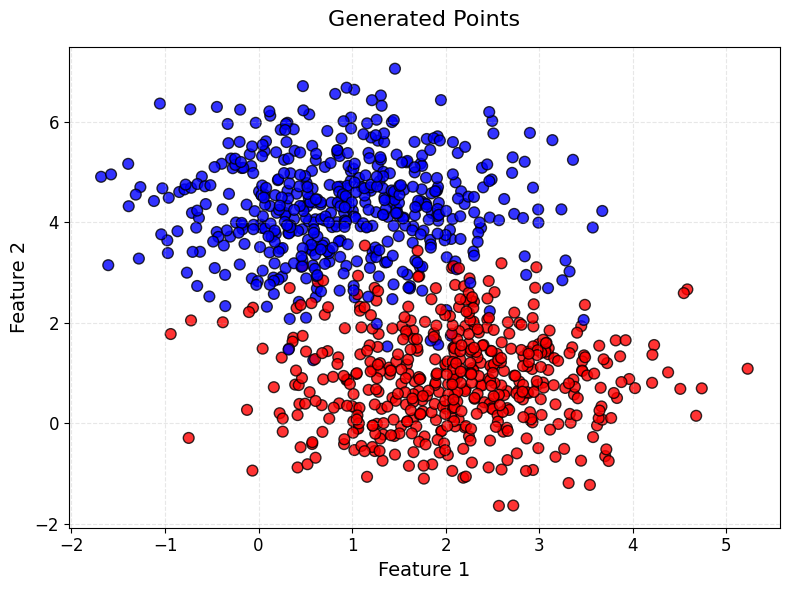

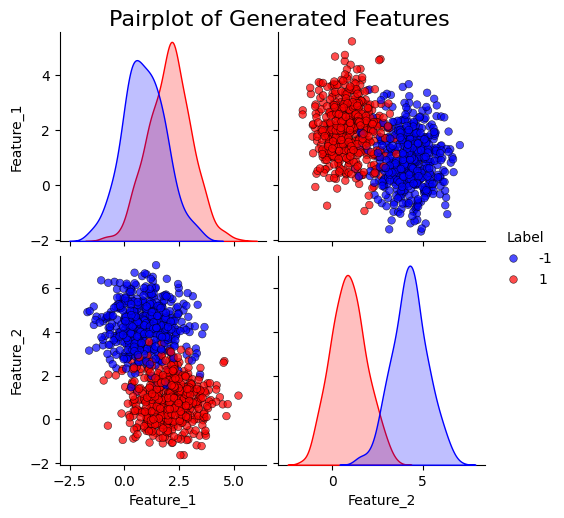

In [15]:
X, y = generate_points(n=1000, n_features=2, centers=2, plot=True, pairplot=True)

### Data preparation - split labeled/unlabeled + compute distance matrices

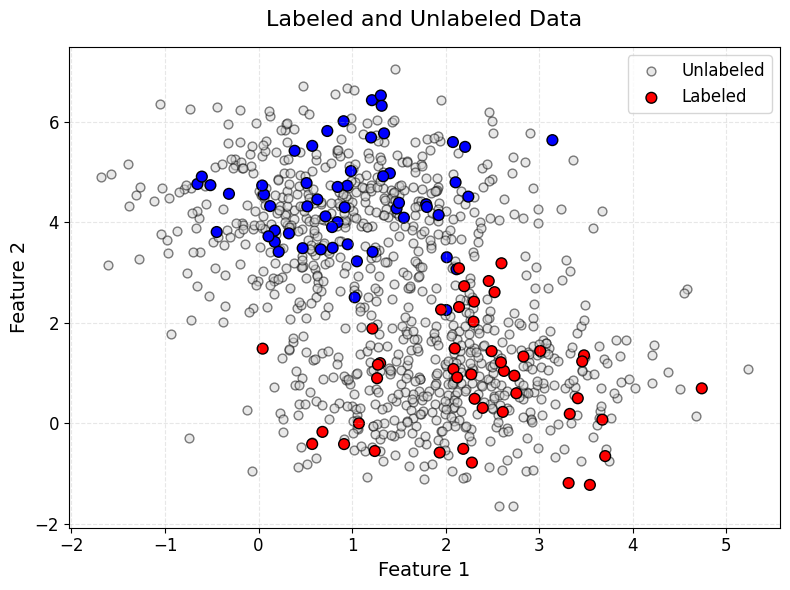

In [16]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled, W_labeled, W_unlabeled = data_preparation(X, y, labeled_size=0.1, plot=True)

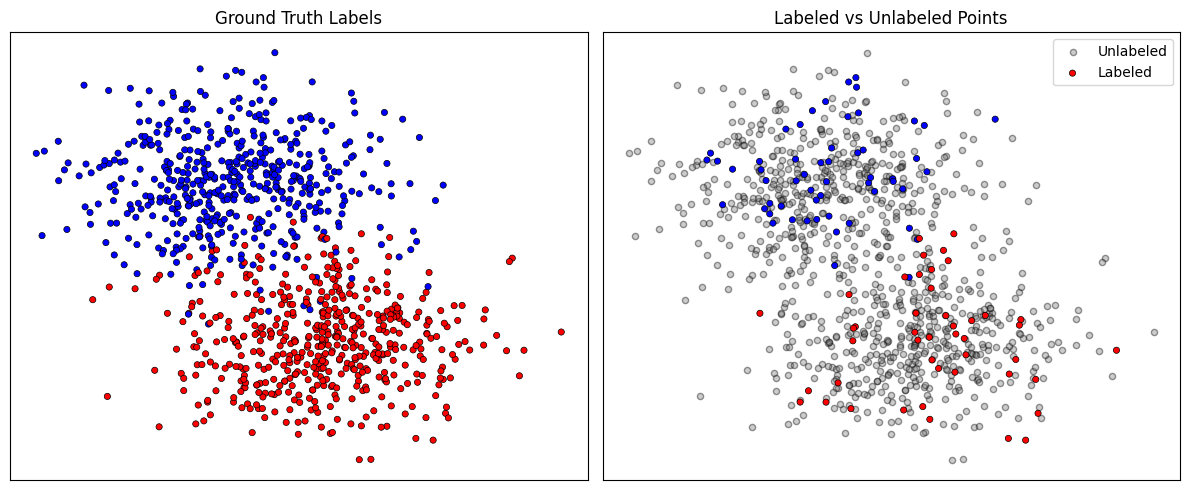

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
colors = ['red', 'blue']

# Plot 1: Ground truth
axs[0].scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=20, edgecolors='k', linewidths=0.5)
axs[0].set_title("Ground Truth Labels")
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot 2: Labeled vs Unlabeled
axs[1].scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c='gray',edgecolors='k', s=20, label='Unlabeled', alpha=0.4)
axs[1].scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, cmap='bwr', s=20, edgecolors='k', linewidths=0.5, label='Labeled')
axs[1].set_title("Labeled vs Unlabeled Points")
axs[1].legend()
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.tight_layout()
plt.show()

In [18]:
# Randomly initialize predicted labels
y0 = np.random.choice([-1,1], len(y_unlabeled))

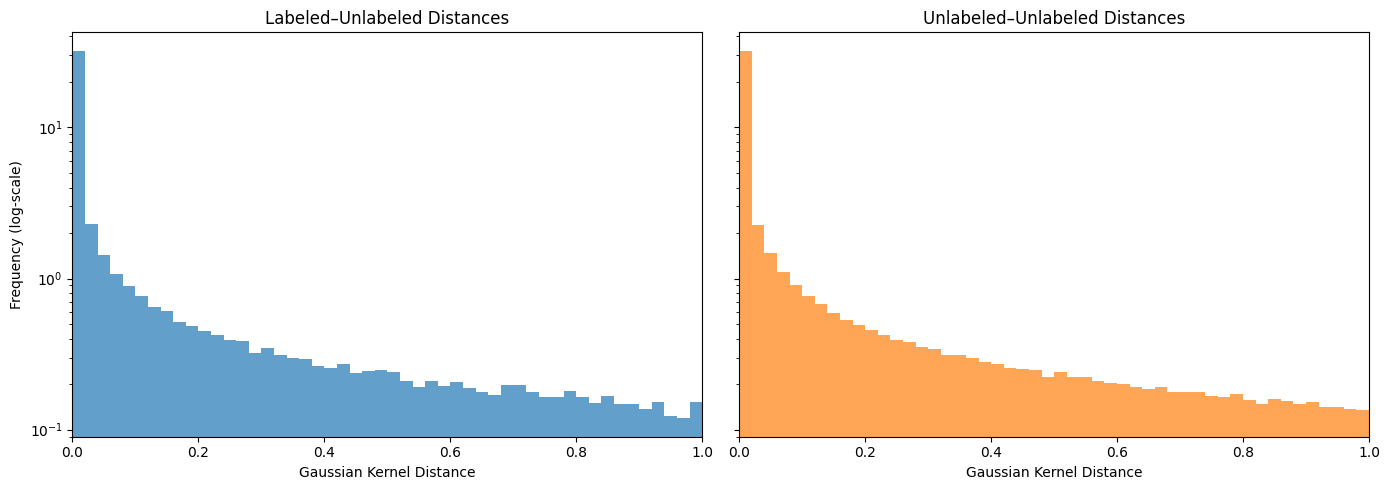

In [19]:
dist_labeled = W_labeled.flatten()
dist_unlabeled = W_unlabeled[np.triu_indices_from(W_unlabeled, k=1)]

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Labeled–Unlabeled distances
axs[0].hist(dist_labeled, bins=50, alpha=0.7, color='tab:blue', density=True)
axs[0].set_xlim(0, 1)
axs[0].set_yscale('log')
axs[0].set_title("Labeled–Unlabeled Distances")
axs[0].set_xlabel("Gaussian Kernel Distance")
axs[0].set_ylabel("Frequency (log-scale)")

# Unlabeled–Unlabeled distances
axs[1].hist(dist_unlabeled, bins=50, alpha=0.7, color='tab:orange', density=True)
axs[1].set_xlim(0, 1)
axs[1].set_yscale('log')
axs[1].set_title("Unlabeled–Unlabeled Distances")
axs[1].set_xlabel("Gaussian Kernel Distance")

plt.tight_layout()
plt.show()

In [20]:
# Initialization of the objective function
safe_updates_f, fast_updates_f, loss, hessian = objective_function(y_labeled, W_labeled, W_unlabeled)

### Gradient descent execution

In [21]:
y_pred_gd, f_history_gd, accuracy_history_gd, time_history_gd = GD_update(safe_updates_f, y0, hessian, num_iters=100000)

Running GD:   0%|          | 109/100000 [00:14<3:45:25,  7.39it/s]


Converged after 109 iterations


### Coordinate minimization - Jacobi scheme execution

In [22]:
y_pred_coord, f_history_coord, accuracy_history_coord, time_history_coord = coord_min_jacobi(W_unlabeled, W_labeled, y_labeled, y0, loss, num_iters=100000)

Running Coordinate Jacobi:   0%|          | 52/100000 [00:05<2:59:46,  9.27it/s]


Converged after 52 iterations


### Block Coordinate Gradient Descent - Gauss-Southwell execution

In [23]:
y_pred, f_history_bcgd, accuracy_history_bcgd, time_history_bcgd = BCGD_GS(fast_updates_f, safe_updates_f, y0, hessian, num_iters=200000, tol=1e-12)

Running BCGD:  39%|███▉      | 78754/200000 [01:02<01:36, 1254.13it/s]


Converged after 78754 iterations


## Plots

### Accuracy vs iterations

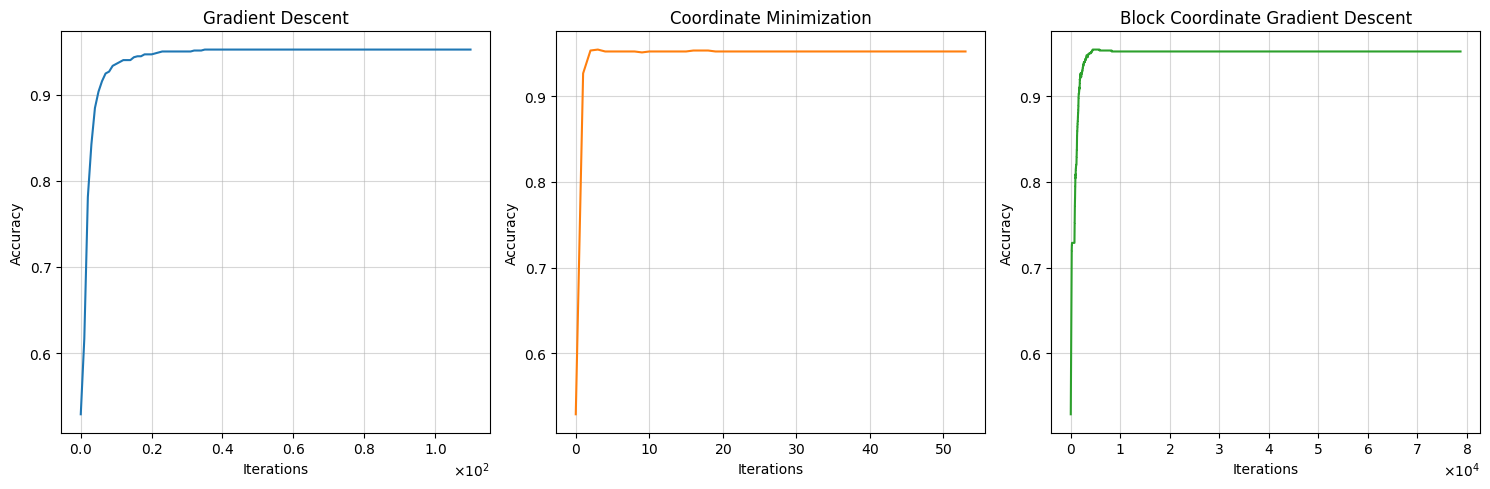

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Gradient Descent
axs[0].plot(accuracy_history_gd, label='Gradient Descent', color='tab:blue')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Iterations')
axs[0].set_title('Gradient Descent')
axs[0].grid(True, alpha=0.5)

# Plot for Coordinate Descent
axs[1].plot(accuracy_history_coord, label='Coordinate Propagation', color='tab:orange')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].set_title('Coordinate Minimization')
axs[1].grid(True, alpha=0.5)

# Plot for Block Coordinate GD
axs[2].plot(accuracy_history_bcgd, label='Block Coordinate GD', color='tab:green')
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Block Coordinate Gradient Descent')
axs[2].grid(True, alpha=0.5)
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))
axs[0].xaxis.set_major_formatter(formatter)
axs[1].xaxis.set_major_formatter(formatter)
axs[2].xaxis.set_major_formatter(formatter)


plt.tight_layout()
plt.show()

In [25]:
print(f"Accuracy GD: {accuracy_history_gd[-1]}")
print(f"Accuracy Coordinate: {accuracy_history_coord[-1]}")
print(f"Accuracy BCGD: {accuracy_history_bcgd[-1]}")

Accuracy GD: 0.9522222222222222
Accuracy Coordinate: 0.9522222222222222
Accuracy BCGD: 0.9522222222222222


In [26]:
print(f"Loss GD: {f_history_gd[-1]}")
print(f"Loss Coordinate: {f_history_coord[-1]}")
print(f"Loss BCGD: {f_history_bcgd[-1]}")

Loss GD: 3670.9528775287304
Loss Coordinate: 3670.917833112063
Loss BCGD: 3725.703714475873


### Accuracy vs CPU time

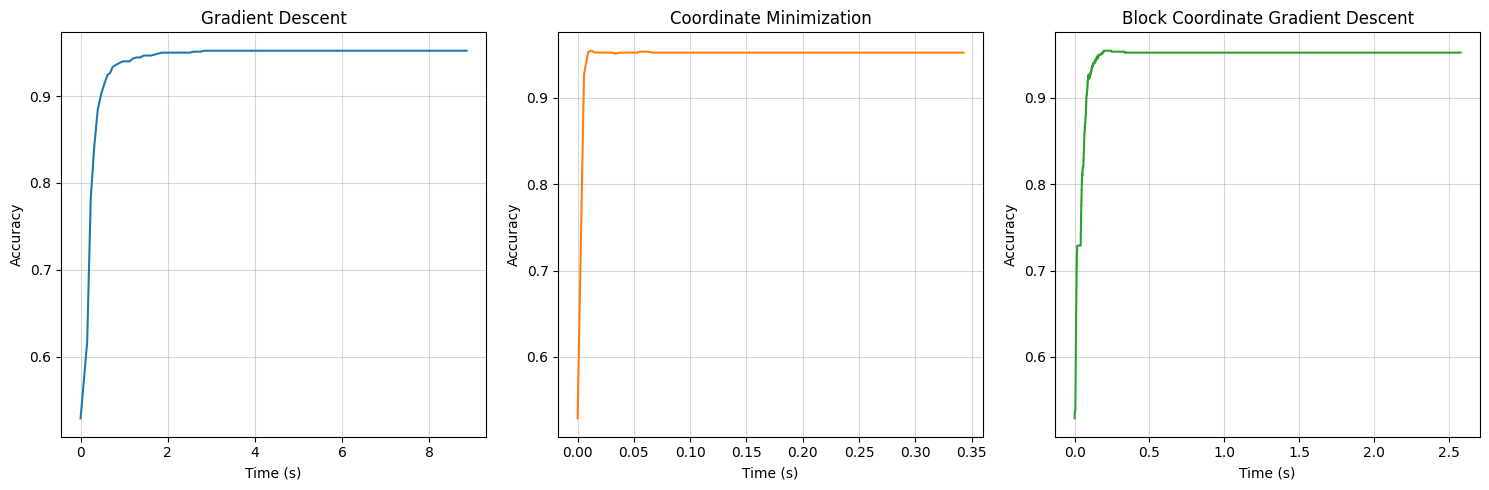

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Gradient Descent
axs[0].plot(time_history_gd, accuracy_history_gd, color='tab:blue')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Gradient Descent')
axs[0].grid(True, alpha=0.5)

# Coordinate Descent
axs[1].plot(time_history_coord, accuracy_history_coord, color='tab:orange')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Coordinate Minimization')
axs[1].grid(True, alpha=0.5)

# Block Coordinate Gradient Descent
axs[2].plot(time_history_bcgd, accuracy_history_bcgd, color='tab:green')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Block Coordinate Gradient Descent')
axs[2].grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

### Loss vs iterations

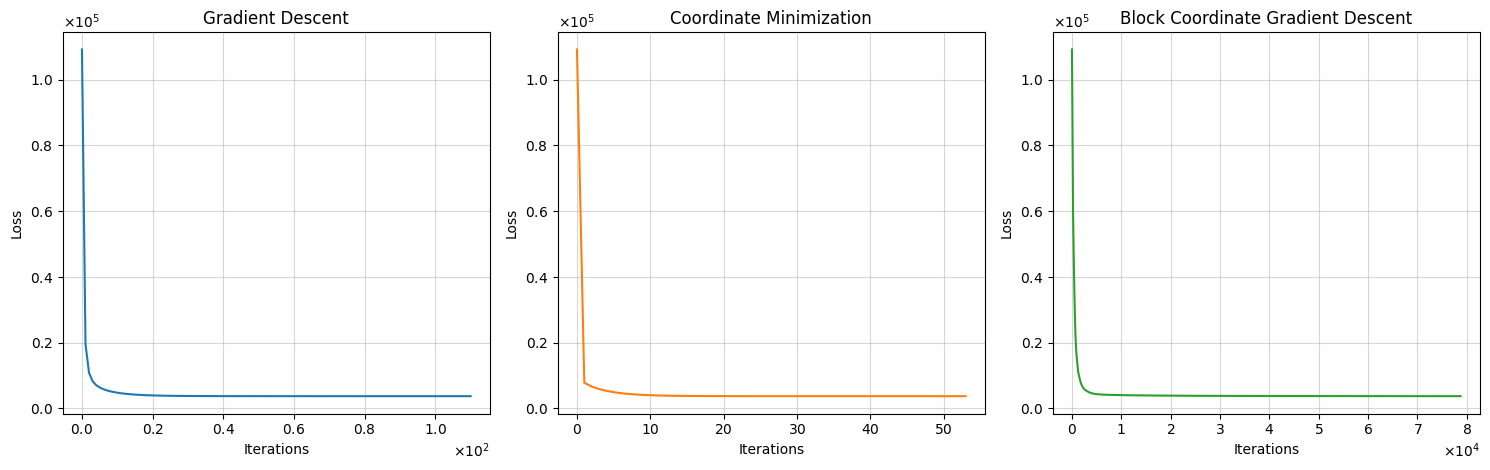

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Gradient Descent
axs[0].plot(f_history_gd, color='tab:blue')
axs[0].set_title('Gradient Descent')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss')
axs[0].grid(True, alpha=0.5)

# Plot for Coordinate Descent
axs[1].plot(f_history_coord, color='tab:orange')
axs[1].set_title('Coordinate Minimization')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Loss')
axs[1].grid(True, alpha=0.5)

# Plot for Block Coordinate GD
axs[2].plot(f_history_bcgd, color='tab:green')
axs[2].set_title('Block Coordinate Gradient Descent')
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('Loss')
axs[2].grid(True, alpha=0.5)

# Create separate formatter instances for each axis
for ax in axs:
    # X-axis formatters
    x_formatter = ScalarFormatter(useMathText=True)
    x_formatter.set_scientific(True)
    x_formatter.set_powerlimits((-2, 2))
    ax.xaxis.set_major_formatter(x_formatter)

    # Y-axis formatters
    y_formatter = ScalarFormatter(useMathText=True)
    y_formatter.set_scientific(True)
    y_formatter.set_powerlimits((-2, 2))
    ax.yaxis.set_major_formatter(y_formatter)

plt.tight_layout()
plt.show()

### Prediction plot

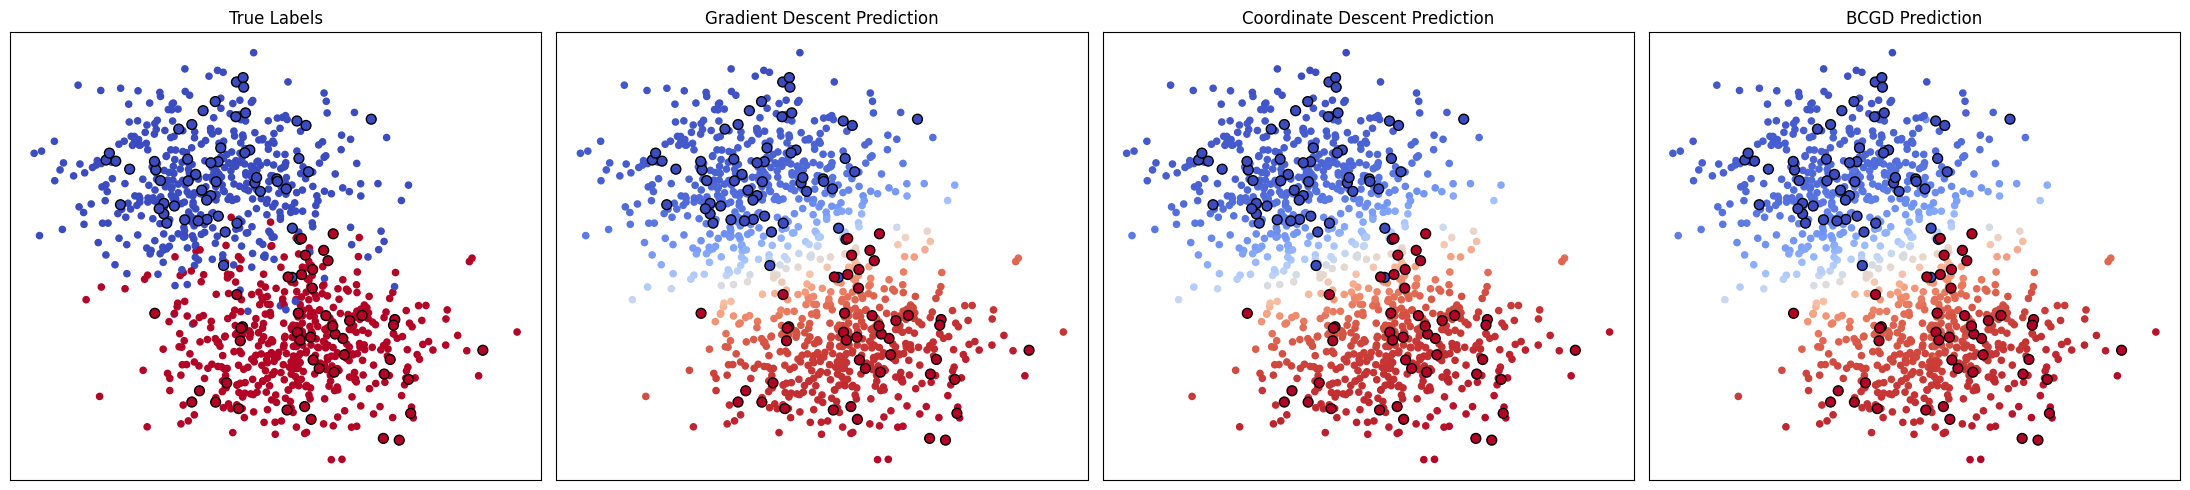

In [29]:
fig, axs = plt.subplots(1, 4, figsize=(22, 5))

def plot_with_labeled(ax, X_labeled, y_labeled, X_unlabeled, y_pred, title):
    ax.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_pred, cmap='coolwarm', s=20, label='Unlabeled')
    ax.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, cmap='coolwarm', s=50, edgecolors='k', linewidths=1, marker='o', label='Labeled')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Plot with true labels
plot_with_labeled(axs[0], X_labeled, y_labeled, X_unlabeled, y_unlabeled, 'True Labels')

# Gradient Descent
plot_with_labeled(axs[1], X_labeled, y_labeled, X_unlabeled, y_pred_gd, 'Gradient Descent Prediction')

# Coordinate Descent
plot_with_labeled(axs[2], X_labeled, y_labeled, X_unlabeled, y_pred_coord, 'Coordinate Descent Prediction')

# BCGD
plot_with_labeled(axs[3], X_labeled, y_labeled, X_unlabeled, y_pred, 'BCGD Prediction')

plt.tight_layout()
plt.show()

## Experiment execution - real dataset

### Download data - bank


=== PCA Analysis ===
Component 1: 76.13% variance explained
Component 2: 14.19% variance explained

Top features per PC1:
- skewness: 0.810
- curtosis: -0.550
- entropy: -0.145

Top features per PC2:
- variance: 0.802
- entropy: 0.444
- curtosis: -0.300


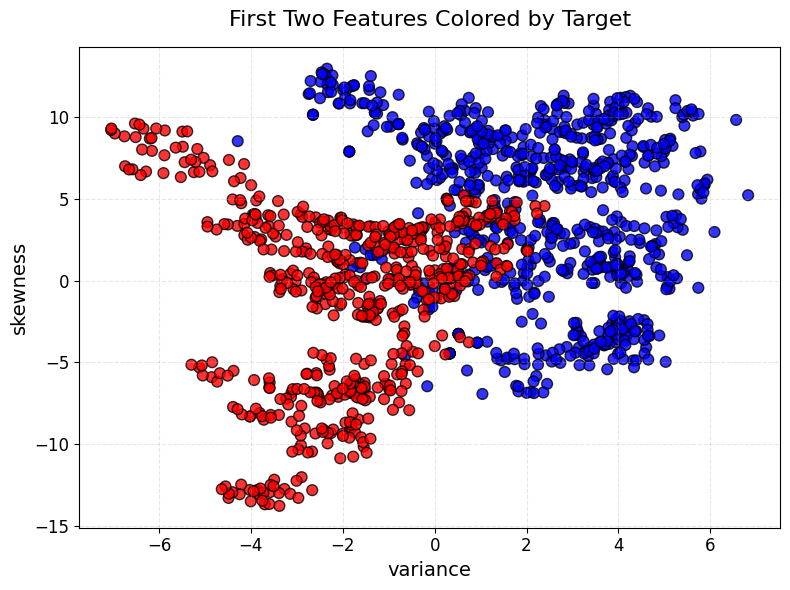

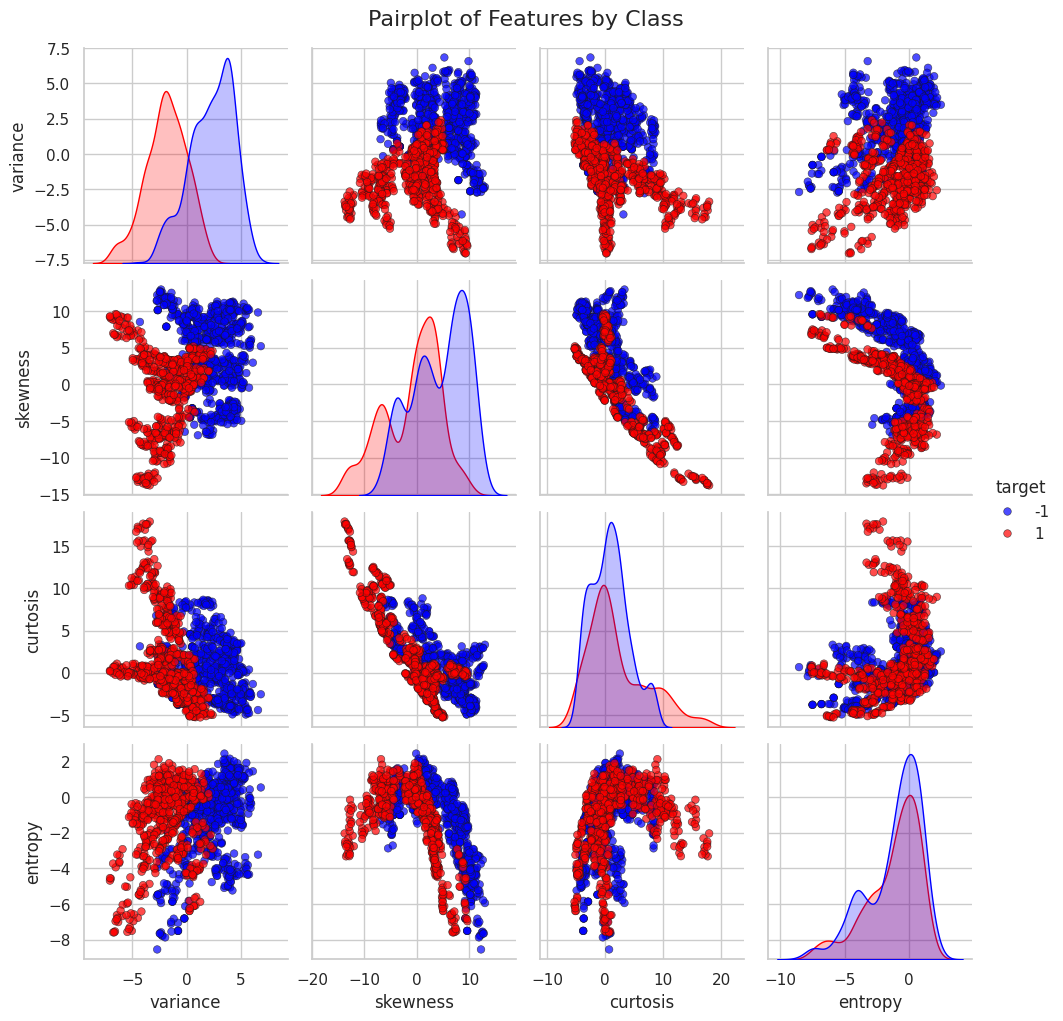

In [30]:
X, y = download_bank(plot=True, pairplot=True, pca_analysis=True)

### Data preparation - split labeled/unlabeled + compute distance matrices

In [31]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled, W_labeled, W_unlabeled = data_preparation(X, y, labeled_size=0.1)

In [32]:
# Randomly initialize predicted labels
y0 = np.random.choice([-1,1], len(y_unlabeled))

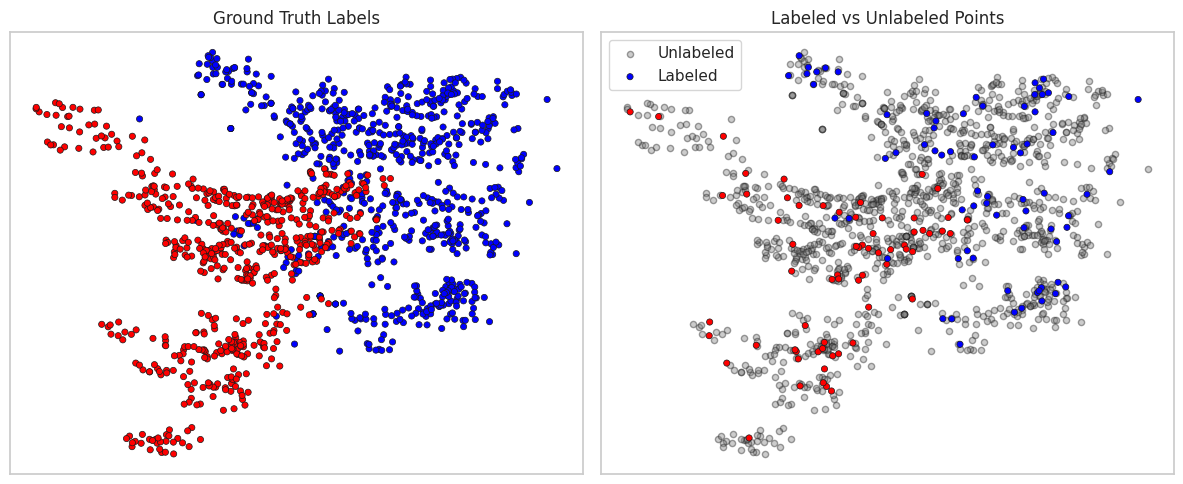

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
colors = ['red', 'blue']

# Plot 1: Ground truth
axs[0].scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=20, edgecolors='k', linewidths=0.5)
axs[0].set_title("Ground Truth Labels")
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot 2: Labeled vs Unlabeled
axs[1].scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c='gray',edgecolors='k', s=20, label='Unlabeled', alpha=0.4)
axs[1].scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, cmap='bwr', s=20, edgecolors='k', linewidths=0.5, label='Labeled')
axs[1].set_title("Labeled vs Unlabeled Points")
axs[1].legend()
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

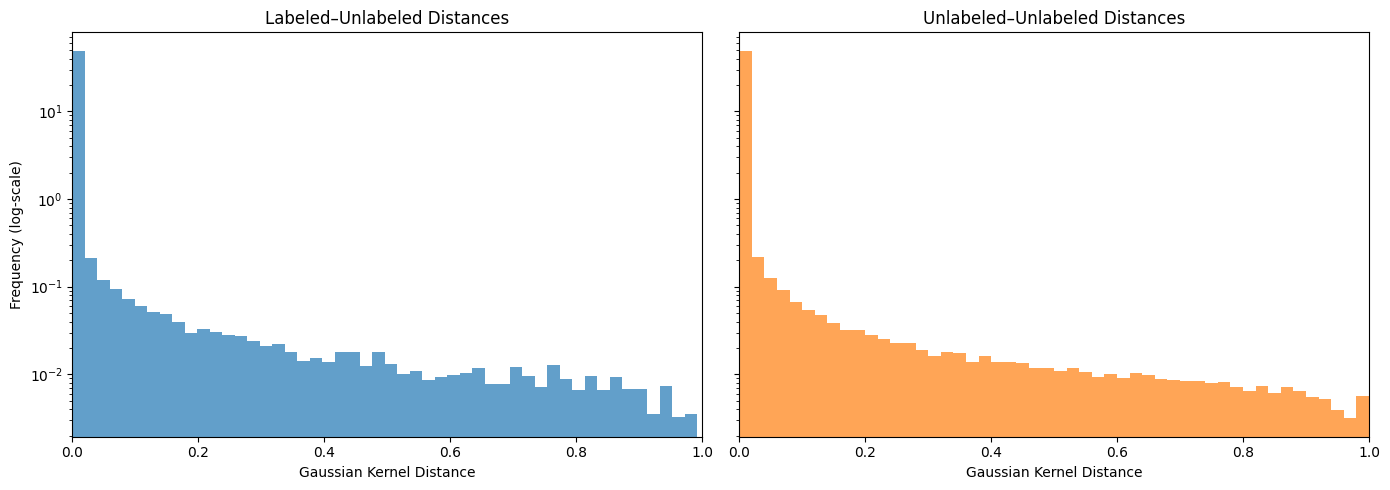

In [34]:
dist_labeled = W_labeled.flatten()
dist_unlabeled = W_unlabeled[np.triu_indices_from(W_unlabeled, k=1)]

plt.clf()
#plt.close('all')
plt.rcdefaults()
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Labeled–Unlabeled distances
axs[0].hist(dist_labeled, bins=50, alpha=0.7, color='tab:blue', density=True)
axs[0].set_xlim(0, 1)
axs[0].set_yscale('log')
axs[0].set_title("Labeled–Unlabeled Distances")
axs[0].set_xlabel("Gaussian Kernel Distance")
axs[0].set_ylabel("Frequency (log-scale)")

# Unlabeled–Unlabeled distances
axs[1].hist(dist_unlabeled, bins=50, alpha=0.7, color='tab:orange', density=True)
axs[1].set_xlim(0, 1)
axs[1].set_yscale('log')
axs[1].set_title("Unlabeled–Unlabeled Distances")
axs[1].set_xlabel("Gaussian Kernel Distance")

plt.tight_layout()
plt.show()

In [35]:
# Initialization of the objective function
safe_updates_f, fast_updates_f, loss, hessian = objective_function(y_labeled, W_labeled, W_unlabeled)

### Gradient Descent execution

In [36]:
y_pred_gd_real, f_history_gd, accuracy_history_gd, time_history_gd = GD_update(safe_updates_f, y0, hessian, num_iters=100000)

Running GD:   7%|▋         | 6848/100000 [12:54<2:55:31,  8.85it/s]


Converged after 6848 iterations


### Coordinate minimization - Jacobi execution

In [37]:
y_pred_coord_real, f_history_coord, accuracy_history_coord, time_history_coord = coord_min_jacobi(W_unlabeled, W_labeled, y_labeled, y0, loss, num_iters=100000)

Running Coordinate Jacobi:   2%|▏         | 2287/100000 [04:29<3:11:52,  8.49it/s]


Converged after 2287 iterations


### Block Coordinate Gradient Descent - Gauss-Southwell execution

In [38]:
y_pred_real, f_history_bcgd, accuracy_history_bcgd, time_history_bcgd = BCGD_GS(fast_updates_f, safe_updates_f, y0, hessian, num_iters=1000000, tol=1e-14)

Running BCGD:  66%|██████▌   | 659558/1000000 [07:14<03:44, 1517.33it/s]


Converged after 659558 iterations


## Plots

### Accuracy vs iterations

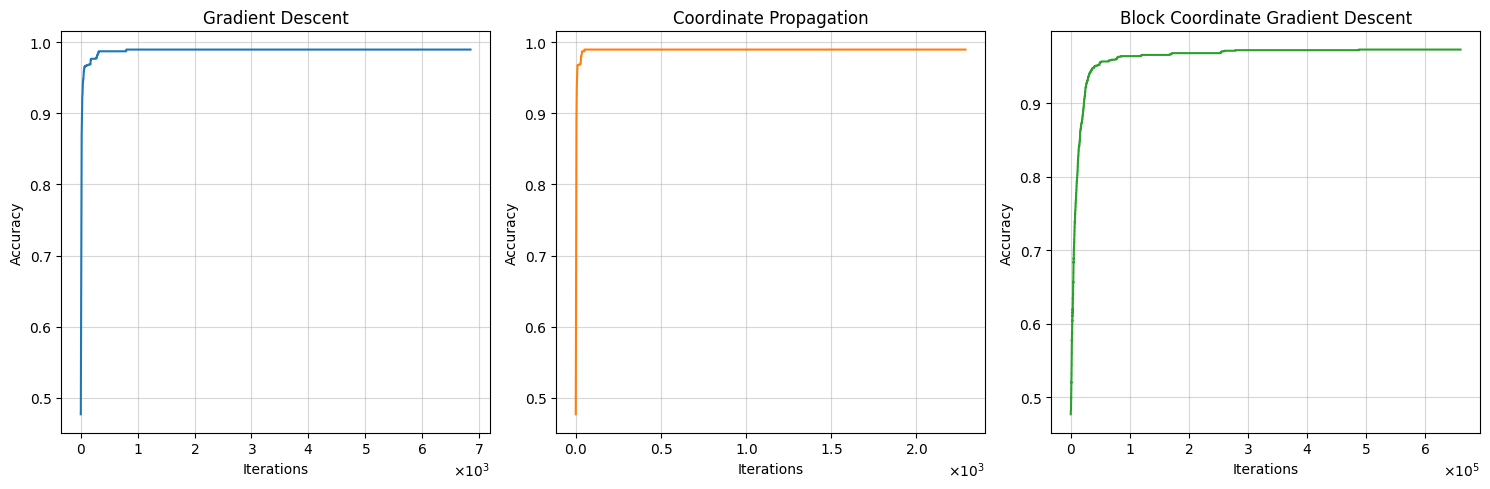

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Gradient Descent
axs[0].plot(accuracy_history_gd, label='Gradient Descent', color='tab:blue')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Iterations')
axs[0].set_title('Gradient Descent')
axs[0].grid(True, alpha=0.5)

# Plot for Coordinate Descent
axs[1].plot(accuracy_history_coord, label='Coordinate Minimization', color='tab:orange')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].set_title('Coordinate Propagation')
axs[1].grid(True, alpha=0.5)

# Plot for Block Coordinate GD
axs[2].plot(accuracy_history_bcgd, label='Block Coordinate Gradient Descent', color='tab:green')
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Block Coordinate Gradient Descent')
axs[2].grid(True, alpha=0.5)
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))
axs[0].xaxis.set_major_formatter(formatter)
axs[1].xaxis.set_major_formatter(formatter)
axs[2].xaxis.set_major_formatter(formatter)


plt.tight_layout()
plt.show()

In [40]:
print(f"Accuracy GD: {accuracy_history_gd[-1]}")
print(f"Accuracy Coordinate: {accuracy_history_coord[-1]}")
print(f"Accuracy BCGD: {accuracy_history_bcgd[-1]}")

Accuracy GD: 0.9894736842105263
Accuracy Coordinate: 0.9894736842105263
Accuracy BCGD: 0.9732793522267207


In [41]:
print(f"Loss GD: {f_history_gd[-1]}")
print(f"Loss Coordinate: {f_history_coord[-1]}")
print(f"Loss BCGD: {f_history_bcgd[-1]}")

Loss GD: 2.7607690526526487
Loss Coordinate: 2.7507675499683946
Loss BCGD: 12.338858911798162


### Accuracy vs CPU time

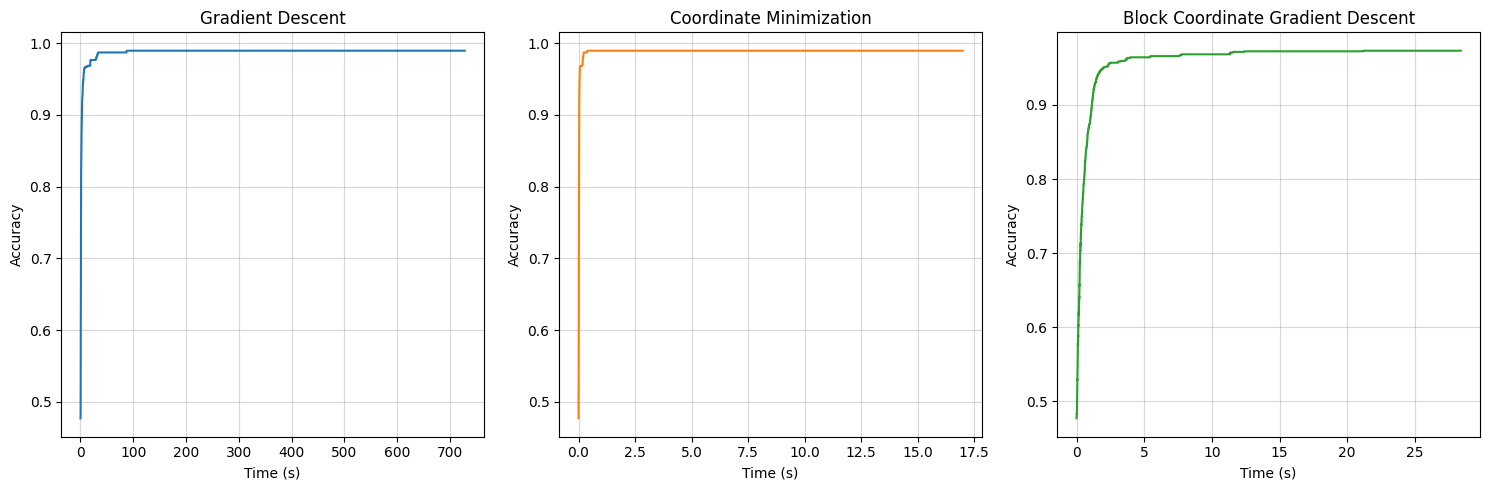

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Gradient Descent
axs[0].plot(time_history_gd, accuracy_history_gd, color='tab:blue')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Gradient Descent')
axs[0].grid(True, alpha=0.5)

# Coordinate Descent
axs[1].plot(time_history_coord, accuracy_history_coord, color='tab:orange')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Coordinate Minimization')
axs[1].grid(True, alpha=0.5)

# Block Coordinate Gradient Descent
axs[2].plot(time_history_bcgd, accuracy_history_bcgd, color='tab:green')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Block Coordinate Gradient Descent')
axs[2].grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

### Loss vs iterations

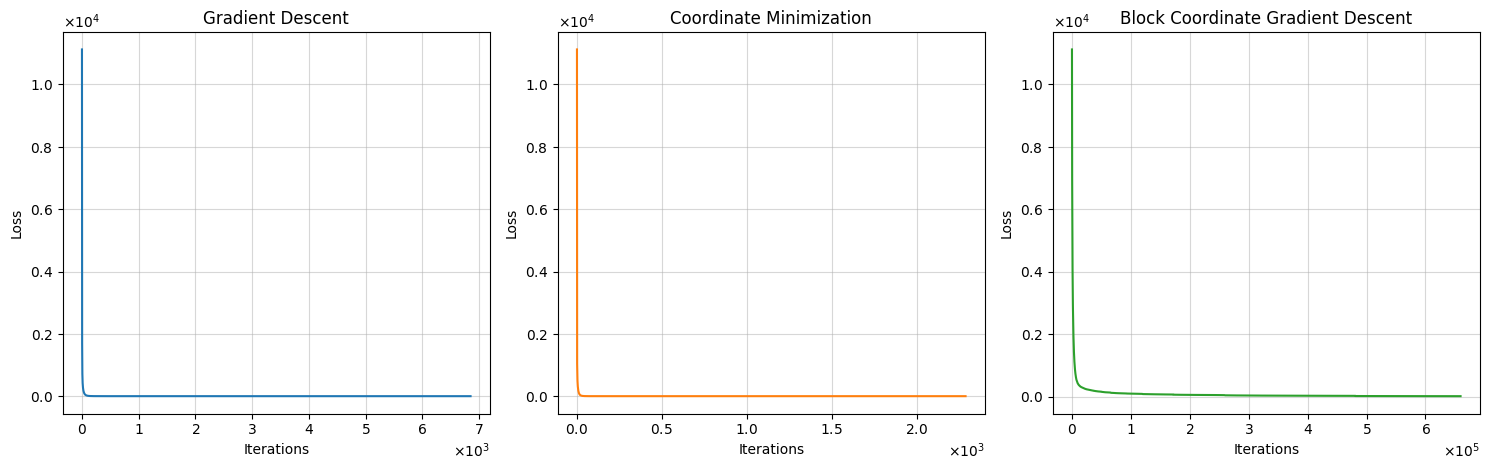

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Gradient Descent
axs[0].plot(f_history_gd, color='tab:blue')
axs[0].set_title('Gradient Descent')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss')
axs[0].grid(True, alpha=0.5)

# Plot for Coordinate Minimization
axs[1].plot(f_history_coord, color='tab:orange')
axs[1].set_title('Coordinate Minimization')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Loss')
axs[1].grid(True, alpha=0.5)

# Plot for Block Coordinate Gradient Descent
axs[2].plot(f_history_bcgd, color='tab:green')
axs[2].set_title('Block Coordinate Gradient Descent')
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('Loss')
axs[2].grid(True, alpha=0.5)

# Create separate formatter instances for each axis
for ax in axs:
    # X-axis formatters
    x_formatter = ScalarFormatter(useMathText=True)
    x_formatter.set_scientific(True)
    x_formatter.set_powerlimits((-2, 2))
    ax.xaxis.set_major_formatter(x_formatter)

    # Y-axis formatters
    y_formatter = ScalarFormatter(useMathText=True)
    y_formatter.set_scientific(True)
    y_formatter.set_powerlimits((-2, 2))
    ax.yaxis.set_major_formatter(y_formatter)

plt.tight_layout()
plt.show()

### Prediction plot

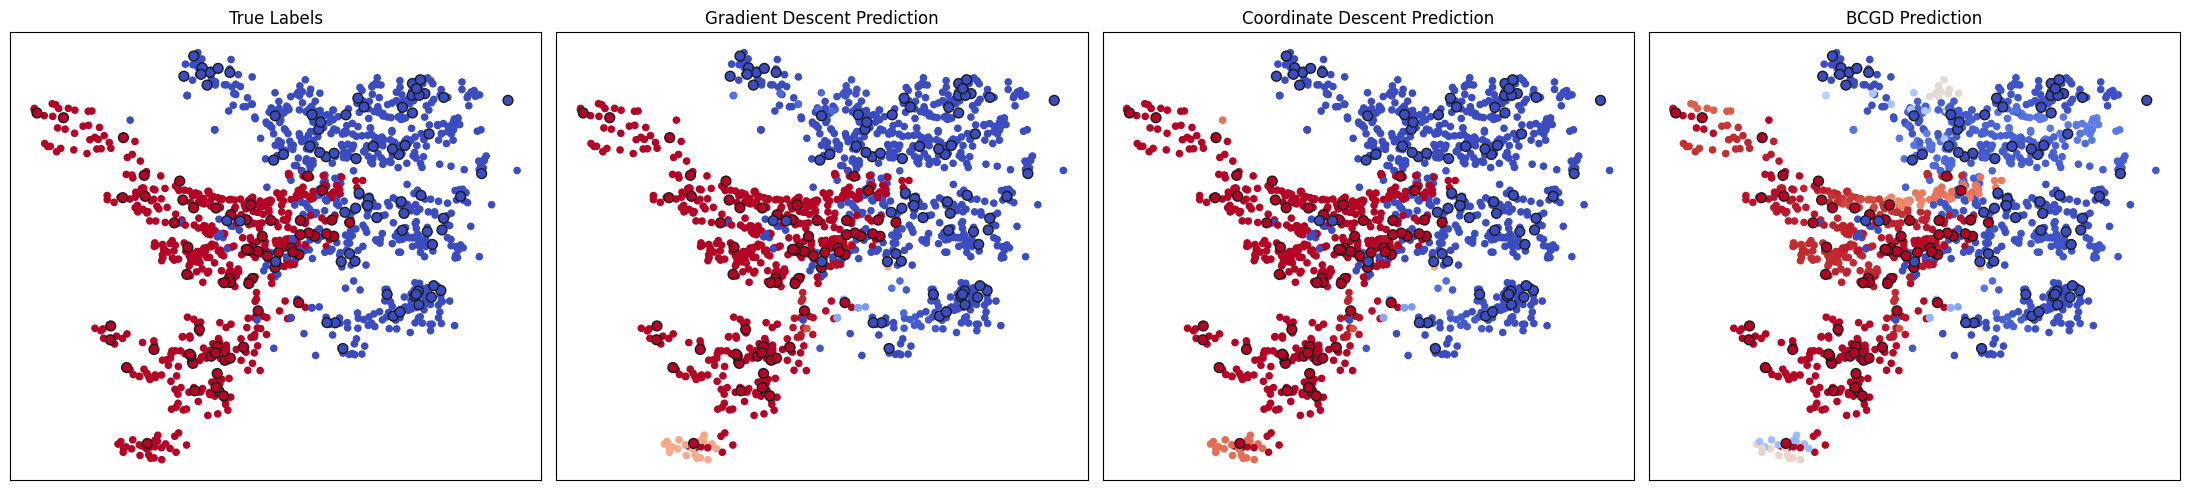

In [44]:
fig, axs = plt.subplots(1, 4, figsize=(22, 5))

def plot_with_labeled(ax, X_labeled, y_labeled, X_unlabeled, y_pred, title):
    ax.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_pred, cmap='coolwarm', s=20, label='Unlabeled')
    ax.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, cmap='coolwarm', s=50, edgecolors='k', linewidths=1, marker='o', label='Labeled')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Plot with true labels
plot_with_labeled(axs[0], X_labeled, y_labeled, X_unlabeled, y_unlabeled, 'True Labels')

# Gradient Descent
plot_with_labeled(axs[1], X_labeled, y_labeled, X_unlabeled, y_pred_gd_real, 'Gradient Descent Prediction')

# Coordinate Descent
plot_with_labeled(axs[2], X_labeled, y_labeled, X_unlabeled, y_pred_coord_real, 'Coordinate Descent Prediction')

# BCGD
plot_with_labeled(axs[3], X_labeled, y_labeled, X_unlabeled, y_pred_real, 'BCGD Prediction')

plt.tight_layout()
plt.show()

In [45]:
print(f"Accuracy GD: {accuracy_history_gd[-1]}")
print(f"Accuracy Coordinate: {accuracy_history_coord[-1]}")
print(f"Accuracy BCGD: {accuracy_history_bcgd[-1]}")

Accuracy GD: 0.9894736842105263
Accuracy Coordinate: 0.9894736842105263
Accuracy BCGD: 0.9732793522267207
